# Comparing boost %s

We compare the performance of different boost %s — that is, multiplying `recommendedGasPrice` (as returned by the Ethereum provider) by some constant — on a simulated Airnode using historical gas price data.

In [1]:
import bisect
import datetime
import random
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import _airnode_sim_utils

API3_PURPLE = '#7963B2'
API3_EMERALD = '#7CE3CB'

to_date_str = lambda ts: datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

# Get historical gas price data

In [2]:
file_patterns = [
    '../gas_prices_2020-03-11_2020-03-13_100%-sampling*',
    '../gas_prices_2020-03-13_2020-03-14_100%-sampling*'
]

df = _airnode_sim_utils.load_data(file_patterns)
df

340 total files.


,blockNum,timeStamp,txnID,gasPrice
0,9646854,1583884773,0x1eb4d0a5e7702cf65d4a2e49743989cfc39a005d7d70...,40.000000
1,9646854,1583884773,0x1906edf9ba5a06ad9870910892b4a34bc1d2fe3885ef...,10.000000
2,9646854,1583884773,0xd9867d0d23048a0a7afa255c411597aac87dde6b7c58...,10.000000
3,9646854,1583884773,0x0ce33d9fd0a59f3b9d8fe16c51c24bd5f1eea6b9f479...,10.000000
4,9646854,1583884773,0x6e27c8fe7fa22d438e635e7085d0f971ee4e0438638d...,12.000000
...,...,...,...,...
2311300,9666211,1584143961,0xf4a8a769fa52ff5e2e5de24e8fa0e064d4169220140a...,10.000000
2311301,9666211,1584143961,0x671c031fc4901d4e8af3ef0bd39183f44e733350170a...,10.000001
2311302,9666211,1584143961,0x5ac5b6b2f8d332bac977bd4234f48865af212f4c5c2f...,12.000000
2311303,9666211,1584143961,0x9101913acca25b62dfe36ec2ec71600be16b44c3df78...,10.000000


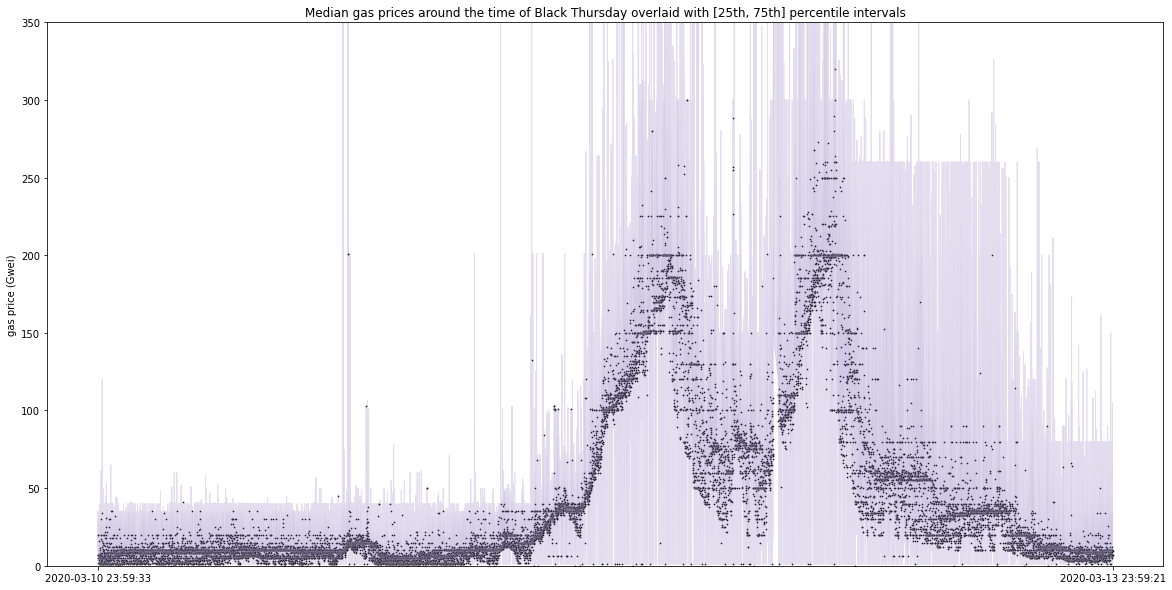

In [3]:
_airnode_sim_utils.plot_gas_prices(df)

# Runing Airnode Sim
**Note**: in order to predict whether or not our txn gets mined, we utilize probabilities computed from our [previous analysis](https://github.com/sassmilic/historical-gas-prices/blob/master/live-testing/notebooks/live%20test%20analysis%20v0.1.ipynb) based on live data, namely:

In [23]:
print('''
    (0, 0]\t9.8%\t(N=102)
    (0, 25]\t84.4%\t(N=205)
    (25, 50]\t93.8%\t(N=192)
    (50, 75]\t95.5%\t(N=156)
    (75, 100]\t97.4%\t(N=114)
    (100, 100]\t100.0%\t(N=1)
''')


    (0, 0]	9.8%	(N=102)
    (0, 25]	84.4%	(N=205)
    (25, 50]	93.8%	(N=192)
    (50, 75]	95.5%	(N=156)
    (75, 100]	97.4%	(N=114)
    (100, 100]	100.0%	(N=1)



That is, if our txn $t$ has a gas price less than all gas prices in the next block $B$ (i.e. $t$ is in the 0th percentile of $B$), then it has a 9.8% chance of getting mined. If its percentile is in the range (0, 25], then it has a 84.4% chance of getting mined, and so on ... 

In [4]:
'''
We randomly select when the Airnode starts running.
To ensure enough historical blocks to compute recommended gas price, 
we start approx. 5 minutes after our historical data starts.
Similar reasoning for end time.
'''

'''
airnode_start_ts = df.iloc[0]['timeStamp'] + random.randint(5 * 60, 6 * 60)
print(f'Airnode sim start time: {to_date_str(airnode_start_ts)}')

airnode_end_ts = df.iloc[-1]['timeStamp'] - random.randint(5 * 60, 6 * 60)
print(f'Airnode sim end time: {to_date_str(airnode_end_ts)}')

airnode_wake_up_times = range(airnode_start_ts, airnode_end_ts, 60)
gps = ['boosted_' + str(x) for x in np.arange(0.8, 1.6, 0.02)]
df_result = _airnode_sim_utils.airnode_sim(df, airnode_wake_up_times, gps)

df_result.to_csv('airnode_sim_results-boosted-black_thursday.csv', index=False)
'''
df_result = pd.read_csv('airnode_sim_results-boosted-black_thursday.csv')

In [5]:
df_result['gasPrice'] = df_result['gasPrice'].astype(float)
df_result['method'] = df_result['method'].apply(lambda s: s[:12])
df_result['boost_x'] = df_result['method'].apply(lambda s: float(re.match('boosted_(.+)', s).group(1)))
df_result.head()

,wakeup_ts,method,gasPrice,confirmation_block_num,confirmation_block_seconds,next_block_percentiles,boost_x
0,1583885126,boosted_0.8,4.0,1.0,13.0,"[1.0, 2.702722093, 5.0, 10.0, 88.0]",0.80
1,1583885126,boosted_0.82,4.1,1.0,13.0,"[1.0, 2.702722093, 5.0, 10.0, 88.0]",0.82
2,1583885126,boosted_0.84,4.2,1.0,13.0,"[1.0, 2.702722093, 5.0, 10.0, 88.0]",0.84
3,1583885126,boosted_0.86,4.3,1.0,13.0,"[1.0, 2.702722093, 5.0, 10.0, 88.0]",0.86
4,1583885126,boosted_0.88,4.4,1.0,13.0,"[1.0, 2.702722093, 5.0, 10.0, 88.0]",0.88


In [7]:
def probability_mined_in_single_block(row):
    
    if isinstance(row['next_block_percentiles'], str):
        l = eval(row['next_block_percentiles'])
    else:
        l = list(row['next_block_percentiles'])
    
    next_block_percentiles = list(map(float, l))
    
    mined_liklihood = {
        0:  0.098, # (0, 0]
        1:  0.844, # (0, 25]
        2:  0.938, # (25, 50]
        3:  0.955, # (50, 75]
        4:  0.974, # (75, 100]
        5:  1.0    # (100, 100]
    }
    key = bisect.bisect(next_block_percentiles, row['gasPrice'])
    return mined_liklihood[key]

In [8]:
def total_probability(x):
    
    def _get_total_probability(l, i):
        if i == len(l) - 1:
            return l[i]
        return l[i] + (1 - l[i]) * _get_total_probability(l, i + 1)
    
    return _get_total_probability(x.tolist(), 0)

def expected_confirmation_blocks(ps):
    
    def _get_expected_value(xs, ps, i):
        assert len(xs) == len(ps)
        if i == len(xs) - 1:
            return xs[i] * ps[i]
        return xs[i] * ps[i] + (1 - ps[i]) * _get_expected_value(xs, ps, i + 1)
    
    return _get_expected_value(list(range(1, len(ps) + 2)), ps.tolist() + [1], 0)

In [9]:
df_result['probability_mined'] = df_result.apply(probability_mined_in_single_block, axis=1)

df_probs = df_result.groupby(['wakeup_ts', 'boost_x']).agg({
    'probability_mined': [
        total_probability,
        expected_confirmation_blocks,
    ]
}, as_index=False).reset_index()
df_probs.columns = df_probs.columns.get_level_values(0)[:2].tolist() + df_probs.columns.get_level_values(1)[-2:].tolist()

# Results: $Pr( \text{mined} )$ & $E( \text{block confirmation time} )$ as a function of boost %
We look at the probability of getting mined in < 60 seconds and the expected confirmation time (measured in blocks) as a function of % boost (the multiplier we use with `recommendedGasPrice`).

NOTE: I include boost %s less than 1.0 just so there's some semblance of a baseline.

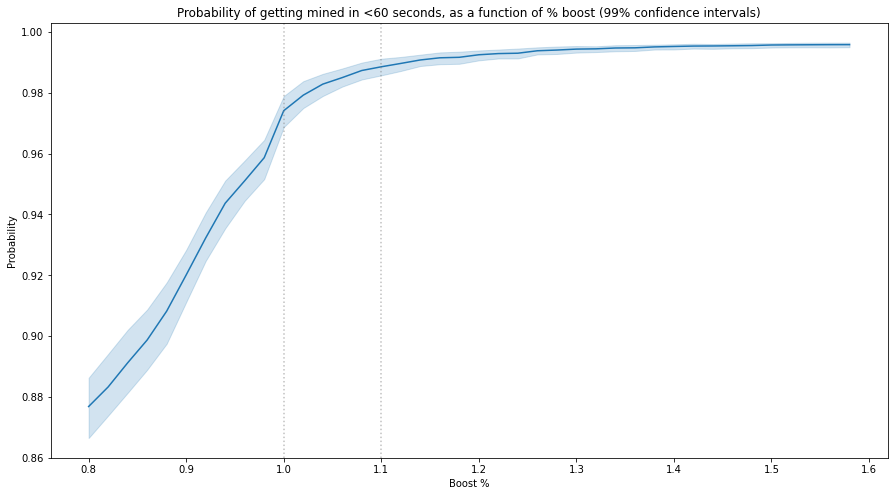

In [10]:
plt.figure(figsize=(15,8))
g = sns.lineplot(data=df_probs, x="boost_x", y="total_probability", ci=99)
plt.axvline(x=1, linestyle='dotted', color=(0.5, 0.5, 0.5, 0.5))
plt.axvline(x=1.1, linestyle='dotted', color=(0.5, 0.5, 0.5, 0.5))
g.set(
    title='Probability of getting mined in <60 seconds, as a function of % boost (99% confidence intervals)',
    xlabel='Boost %',
    ylabel='Probability'
);

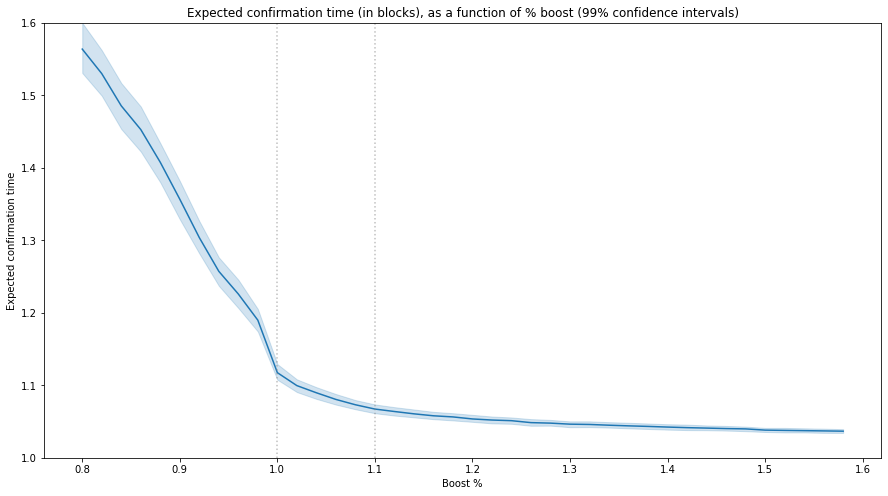

In [11]:
plt.figure(figsize=(15,8))
g = sns.lineplot(data=df_probs, x="boost_x", y="expected_confirmation_blocks", ci=99)
plt.axvline(x=1, linestyle='dotted', color=(0.5, 0.5, 0.5, 0.5))
plt.axvline(x=1.1, linestyle='dotted', color=(0.5, 0.5, 0.5, 0.5))
g.set(
    title='Expected confirmation time (in blocks), as a function of % boost (99% confidence intervals)',
    xlabel='Boost %',
    ylabel='Expected confirmation time',
    ylim=(1.0, 1.6)
);

### Comments
- Interesting that there's a noticeable inflection point at 1.0 (i.e. == recommended gas price)
- Variance decreases as boost % increases, as expected

## Looking closer at distributions
We take a closer look at the distribution of performance of the diferent boost %. That is, while looking at the *mean* performance is important, we also want to see the outliers of these performance distributions; i.e. how these different methods perform in outlier scenarios.

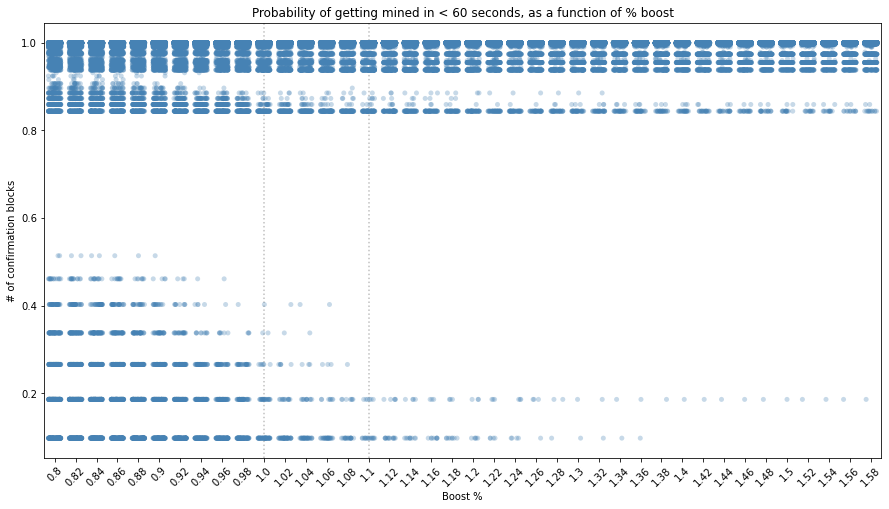

In [12]:
plt.figure(figsize=(15,8))

g = sns.stripplot(
    x="boost_x", y="total_probability", data=df_probs,
    size=5, alpha=0.3, color="steelblue", jitter=0.3
);
g.set(
    title='Probability of getting mined in < 60 seconds, as a function of % boost',
    xlabel='Boost %',
    ylabel='# of confirmation blocks',
    #xticklabels=boost_ranges
);
plt.xticks(rotation=45);
plt.axvline(x=10, linestyle='dotted', color=(0.5, 0.5, 0.5, 0.5));
plt.axvline(x=15, linestyle='dotted', color=(0.5, 0.5, 0.5, 0.5));

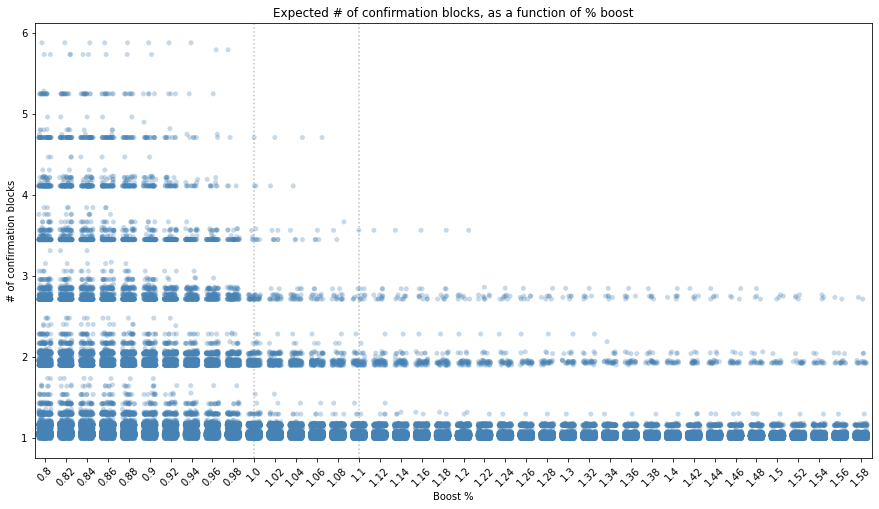

In [13]:
plt.figure(figsize=(15,8))

g = sns.stripplot(
    x="boost_x", y="expected_confirmation_blocks", data=df_probs,
    size=5, alpha=0.3, color="steelblue", jitter=0.3
);
g.set(
    title='Expected # of confirmation blocks, as a function of % boost',
    xlabel='Boost %',
    ylabel='# of confirmation blocks',
    #xticklabels=boost_ranges
);
plt.xticks(rotation=45);
plt.axvline(x=10, linestyle='dotted', color=(0.5, 0.5, 0.5, 0.5));
plt.axvline(x=15, linestyle='dotted', color=(0.5, 0.5, 0.5, 0.5));

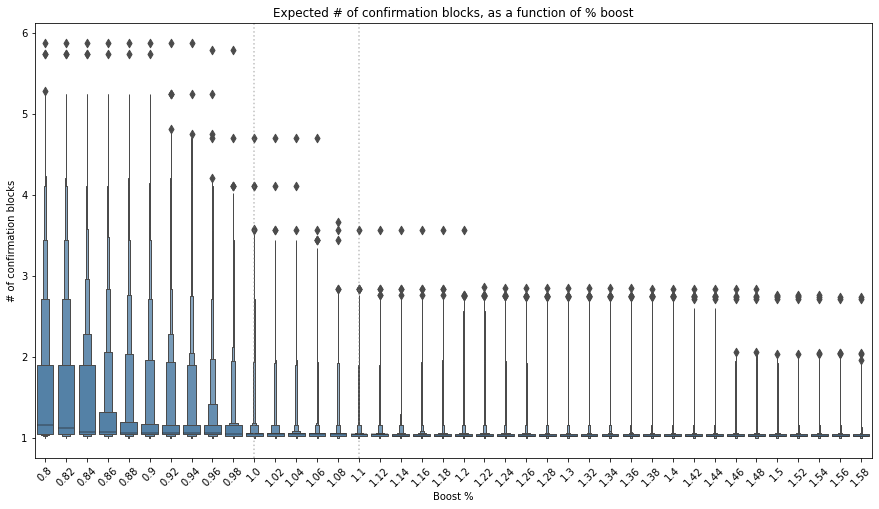

In [14]:
plt.figure(figsize=(15,8))

g = sns.boxenplot(
    x="boost_x", y="expected_confirmation_blocks", data=df_probs, color="steelblue"
);
g.set(
    title='Expected # of confirmation blocks, as a function of % boost',
    xlabel='Boost %',
    ylabel='# of confirmation blocks',
    #xticklabels=boost_ranges
);
plt.xticks(rotation=45);
plt.axvline(x=10, linestyle='dotted', color=(0.5, 0.5, 0.5, 0.5));
plt.axvline(x=15, linestyle='dotted', color=(0.5, 0.5, 0.5, 0.5));

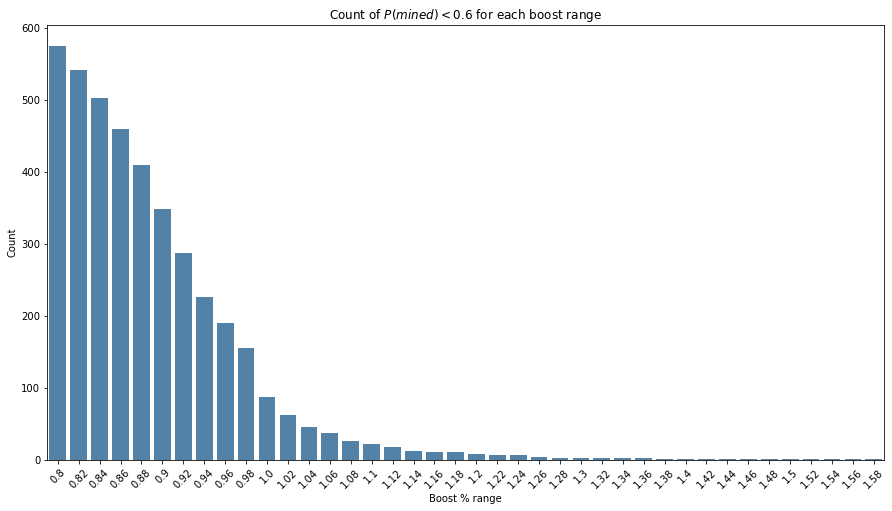

In [15]:
df_ = df_probs[["boost_x", "total_probability"]]
df_ = df_[df_["total_probability"] < 0.6]

plt.figure(figsize=(15,8))

g = sns.countplot(x="boost_x", data=df_, color="steelblue")
g.set(
    title='Count of $P(mined) < 0.6$ for each boost range',
    xlabel='Boost % range',
    ylabel='Count',
);
plt.xticks(rotation=45);

And actual values:

In [16]:
prev_count = None
for bg in df_['boost_x'].unique():
    count = df_.groupby('boost_x').count().loc[bg][0]
    if prev_count:
        percent_change = (prev_count - count) / prev_count * 100
        print(f"{bg:.2f} -> {count}\t ({percent_change:.0f}% decrease)")
    else:
        print(f"{bg:.2f} -> {count}")
    prev_count = count

0.80 -> 575
0.82 -> 541	 (6% decrease)
0.84 -> 503	 (7% decrease)
0.86 -> 460	 (9% decrease)
0.88 -> 410	 (11% decrease)
0.90 -> 349	 (15% decrease)
0.92 -> 287	 (18% decrease)
0.94 -> 226	 (21% decrease)
0.96 -> 190	 (16% decrease)
0.98 -> 155	 (18% decrease)
1.00 -> 87	 (44% decrease)
1.02 -> 63	 (28% decrease)
1.04 -> 46	 (27% decrease)
1.06 -> 37	 (20% decrease)
1.08 -> 26	 (30% decrease)
1.10 -> 22	 (15% decrease)
1.12 -> 18	 (18% decrease)
1.14 -> 13	 (28% decrease)
1.16 -> 11	 (15% decrease)
1.18 -> 11	 (0% decrease)
1.20 -> 8	 (27% decrease)
1.22 -> 7	 (12% decrease)
1.24 -> 7	 (0% decrease)
1.26 -> 4	 (43% decrease)
1.28 -> 3	 (25% decrease)
1.30 -> 2	 (33% decrease)
1.32 -> 2	 (0% decrease)
1.34 -> 2	 (0% decrease)
1.36 -> 2	 (0% decrease)
1.38 -> 1	 (50% decrease)
1.40 -> 1	 (0% decrease)
1.42 -> 1	 (0% decrease)
1.44 -> 1	 (0% decrease)
1.46 -> 1	 (0% decrease)
1.48 -> 1	 (0% decrease)
1.50 -> 1	 (0% decrease)
1.52 -> 1	 (0% decrease)
1.54 -> 1	 (0% decrease)
1.56 -> 1	 (0%

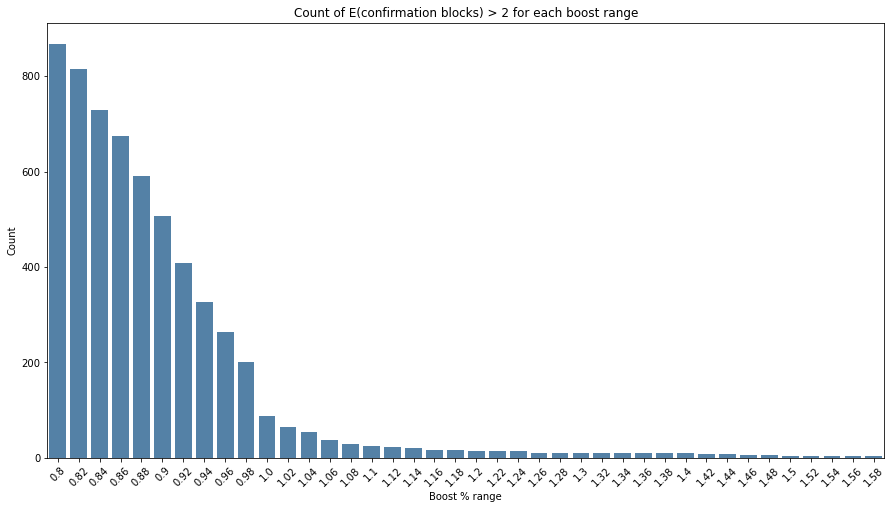

In [17]:
df_ = df_probs[["boost_x", "expected_confirmation_blocks"]]
df_ = df_[df_["expected_confirmation_blocks"] > 2]

plt.figure(figsize=(15,8))

g = sns.countplot(x="boost_x", data=df_, color="steelblue")
g.set(
    title='Count of E(confirmation blocks) > 2 for each boost range',
    xlabel='Boost % range',
    ylabel='Count',
);
plt.xticks(rotation=45);

And actual values:

In [18]:
prev_count = None
for bg in df_['boost_x'].unique():
    count = df_.groupby('boost_x').count().loc[bg][0]
    if prev_count:
        percent_change = (prev_count - count) / prev_count * 100
        print(f"{bg:.2f} -> {count}\t ({percent_change:.0f}% decrease)")
    else:
        print(f"{bg:.2f} -> {count}")
    prev_count = count

0.80 -> 868
0.82 -> 816	 (6% decrease)
0.84 -> 730	 (11% decrease)
0.86 -> 675	 (8% decrease)
0.88 -> 591	 (12% decrease)
0.90 -> 508	 (14% decrease)
0.92 -> 409	 (19% decrease)
0.94 -> 326	 (20% decrease)
0.96 -> 263	 (19% decrease)
0.98 -> 202	 (23% decrease)
1.00 -> 88	 (56% decrease)
1.02 -> 65	 (26% decrease)
1.04 -> 54	 (17% decrease)
1.06 -> 38	 (30% decrease)
1.08 -> 29	 (24% decrease)
1.10 -> 26	 (10% decrease)
1.12 -> 22	 (15% decrease)
1.14 -> 21	 (5% decrease)
1.16 -> 17	 (19% decrease)
1.18 -> 16	 (6% decrease)
1.20 -> 14	 (12% decrease)
1.22 -> 14	 (0% decrease)
1.24 -> 14	 (0% decrease)
1.26 -> 11	 (21% decrease)
1.28 -> 11	 (0% decrease)
1.30 -> 11	 (0% decrease)
1.32 -> 11	 (0% decrease)
1.34 -> 11	 (0% decrease)
1.36 -> 10	 (9% decrease)
1.38 -> 10	 (0% decrease)
1.40 -> 10	 (0% decrease)
1.42 -> 8	 (20% decrease)
1.44 -> 8	 (0% decrease)
1.46 -> 7	 (12% decrease)
1.48 -> 7	 (0% decrease)
1.50 -> 5	 (29% decrease)
1.52 -> 5	 (0% decrease)
1.54 -> 5	 (0% decrease)
1.56

### Comments
In the preceeding graphs, we look at outlier-like data in each group (rather than just central tendencies.) Some notes:
- Interestingly, we see again the "jump" in performance when we go from boost % < 1.0 to boost % == 1 (i.e. exactly `recommendedGasPrice`)
- It seems like 10% boost was a good initial choice:
    - we see a 75% decrease (87 -> 22) in txns unlikely to get mined (**\***)
    - we see a 70% decrease (87 -> 26) in txns with expected confirmation time of > 2 blocks
    - beyond that is arguably diminishing returns
    
(**\***) formally: txns with < 60% chance of being mined within a minute

# Conclusion
- According to several metrics we use, a "boost %" of 10% improves performance by 75%. Going from 10% to 20% appears to provide an additional ~50% improvement *when measured against the 10% boost*.
    - Beyond that, it's arguably diminishing returns.
- We can definitely conclude that using the recommended gas price *as a minimum* is good practice, because the highest "jump" in improvement occurs when our chosen gas price goes from below the recommended amount to exactly the recommended amount (i.e. boost % = 1.0). See any of the above graphs to see this pattern.
- Now, it's ultimately a matter of how much we value this boost in performance (i.e. cost/benefit analysis). Is a 10% increase a lot to pay for this improvement? Or not?
    - Promisingly, even a "small boost" shows notable improvement. (Reminder: the tested boost %s are at the granularity of 0.02% points.) 
    
NOTE: this was all tested on data from Black Thursday (+/- 1 day). It would be good to test on more "normal" data, although I think these patterns would persist. In fact, these patterns (differences between gas selection methods) are likely more pronounced in times of high gas price volatility.